### Fitting BC covid-19 data using an SIR model with varying $\beta(t)$

In [1]:
import matplotlib.pyplot as plt
import torch as tc
import numpy as np
from torchdiffeq import odeint
from torch import nn
from data import get_cases

In [2]:
tc.cuda.is_available()

False

We retrieve the BC data. We have that $S(t) = S_0 - C(t)$, where $C(t)$ is the number of cumulative cases at time $t$.

In [3]:
cases, cum_cases, N = get_cases()

I0 = 1
R0 = 0
S0 = N - I0 - R0
y0 = tc.tensor([S0, I0, R0, N]).float()

data = S0 - cum_cases

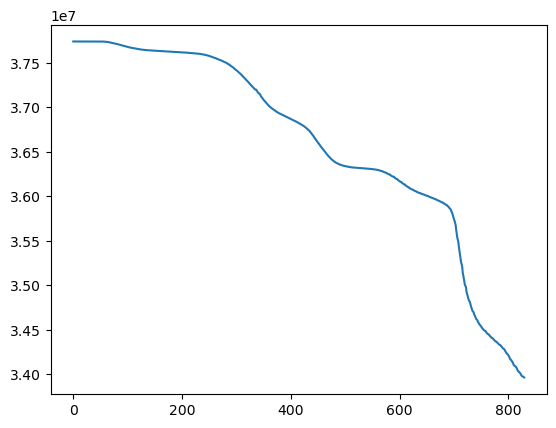

In [4]:
plt.plot(data)

The following corresponds to our model. We model $\beta(t)$ as a fourier series of order 10.

In [5]:
class ODE(nn.Module):

    def __init__(self, y0, data, N):
        super(ODE, self).__init__()

        #initial parameters
        self.gamma = 0.06
        self.y0 = y0
        self.data = tc.tensor(data).float()
        self.N = N
        self.T = self.data.numel()
        self.tspan = tc.arange(0, self.T).float()

        #beta(t) parameters
        self.n = 10
        self.a0 = nn.Parameter(tc.tensor(0.2))
        self.a = nn.Parameter(tc.zeros(self.n - 1))
        self.b = nn.Parameter(tc.zeros(self.n - 1))
        self.sigmoid = nn.Sigmoid()

        #minimum likelihood that can be achieved with the provided loss
        self.min_likelihood = (1/N) * (self.data.mean() - (1/len(self.tspan)) * tc.dot(self.data.log(), self.data)) #when pred = data
        

    def betafn(self, t):
        x = tc.full((self.n - 1,), t.item()) * 2 * tc.pi / self.T - self.T / 2 #scaled input t
        nspan = tc.arange(1, self.n, dtype=float) #n values
        x = nspan * x #element-wise mult.
        return self.sigmoid((1/2) * self.a0 + (self.a * tc.cos(x) + self.b * tc.sin(x)).sum().squeeze())
        
    def forward(self, t, y):
        S, I, R, N = y

        beta = self.betafn(t)
        dS = - beta * S * I / N
        dI = beta * S * I / N - self.gamma * I
        dR = self.gamma * I
        dN = tc.tensor(0.0)

        return tc.stack([dS, dI, dR, dN])
    
    def predict(self):
        S, I, R, N = odeint(self, self.y0, self.tspan).T
        return S, I, R, N
    

    def likelihood(self):
        S, I, R, _ = self.predict()
        return (1/self.N) * (S.mean() - (1/len(self.tspan)) * tc.dot(S.log(), self.data))
    
    def convergence_criteria(self, current_lik, tol=0.01):
        min_lik = self.min_likelihood
        return tc.isclose(current_lik, min_lik, atol=tol)

    

Optimization routine. Since we know the global minimum of the likelihood, we can establish a convergence criteria. We use adam to optimize objective.

In [11]:
func = ODE(y0 = y0, data = data, N = N)

optimizer = tc.optim.Adam(func.parameters(), lr=0.1)

losses = []
i = 0
current_lik = tc.tensor(0.0)
while not func.convergence_criteria(current_lik=current_lik, tol=1e-5):
    optimizer.zero_grad()
    l = func.likelihood()
    current_lik = l.detach().clone()
    l.backward()
    if i%5==0 : print("Loss : {}".format(current_lik))
    optimizer.step()
    losses.append(l.clone().detach())
    i+=1


Loss : -8.968239784240723
Loss : -14.196749687194824
Loss : -14.633702278137207
Loss : -14.778605461120605
Loss : -14.805987358093262
Loss : -14.91203784942627
Loss : -14.89608097076416
Loss : -14.902745246887207
Loss : -15.005561828613281


KeyboardInterrupt: 

In [7]:
print("Minimum Likelihood : {}, Achieved Likelihood : {}, Difference : {}".format(func.min_likelihood, current_lik, tc.abs(func.min_likelihood - current_lik)))

Minimum Likelihood : -15.92385482788086, Achieved Likelihood : -15.923604965209961, Difference : 0.0002498626708984375


Text(0, 0.5, 'Loss')

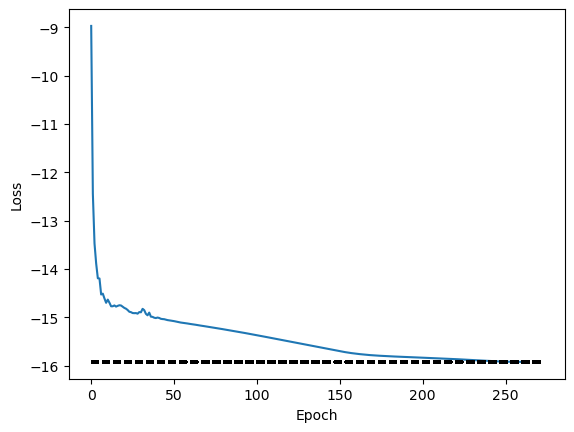

In [8]:
#Losses

plt.plot(tc.stack(losses))
plt.hlines(tc.full((len(losses),), func.min_likelihood), xmin=0, xmax=len(losses)+10, linestyles='--', color='black', alpha=0.4)
plt.xlabel("Epoch")
plt.ylabel("Loss")

Text(0.5, 1.0, '$\\beta (t)$')

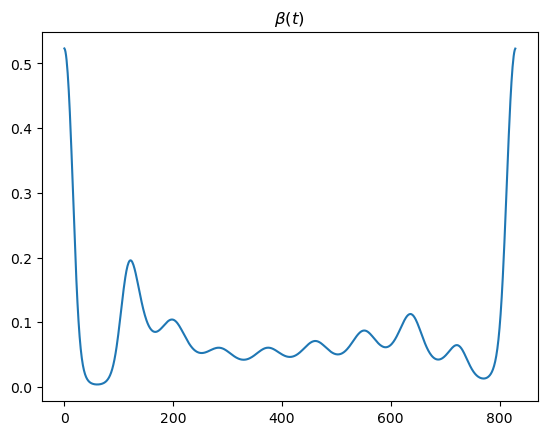

In [9]:
#Beta

plt.plot([func.betafn(tc.tensor([t])).detach().clone() for t in func.tspan])
plt.title(r"$\beta (t)$")

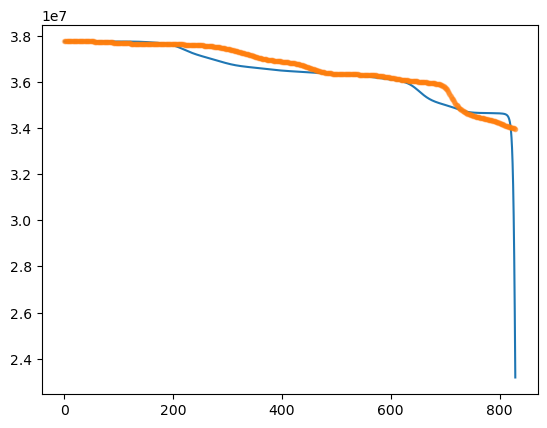

In [10]:
#Fit

S, I, R, _ = func.predict()

plt.plot(S.detach())
plt.plot(data, '.', alpha=0.3)